In [5]:
import xarray as xr
import rioxarray as rio
import numpy as np
import pandas as pd
import os
import glob
import rasterio
import re
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from rasterio.enums import Resampling 


# -----------------------------
# 1. Load the monthly LAI dataset (NetCDF)
# -----------------------------
lai_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/modisLAI/MODIS_LAI_monthly.nc"
ds_lai = xr.open_dataset(lai_path)

# Set spatial dims and CRS
ds_lai = ds_lai.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)
ds_lai = ds_lai.rio.write_crs("EPSG:4326", inplace=True)  # assuming it's lat/lon WGS84

print(ds_lai)
# print(ds_lai.time.values)  # check dates
da = ds_lai['lai']
da.rio  # This will attach rioxarray functionality if not already attached

# Check the CRS
print(da.rio.crs)
print(da.dims)
# Print all timestamps
print(ds_lai.time.values)

<xarray.Dataset> Size: 23MB
Dimensions:      (time: 228, lat: 107, lon: 116)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
    spatial_ref  int64 8B 0
Data variables:
    lai          (time, lat, lon) float64 23MB ...
Attributes:
    citation:       [1] Lin, W., Yuan, H., Dai, Y. et al., 2022. Reprocessed ...
    contact:        Yuan, Hua (yuanh25@mail.sysu.edu.cn)
    creation_date:  20221119
    institution:    Land-Atmosphere Interaction Research Group at Sun Yat-sen...
    title:          LAI data sets for land surface and climate modelling
EPSG:4326
('time', 'lat', 'lon')
['2002-01-31T00:00:00.000000000' '2002-02-28T00:00:00.000000000'
 '2002-03-31T00:00:00.000000000' '2002-04-30T00:00:00.000000000'
 '2002-05-31T00:00:00.000000000' '2002-06-30T00:00:00.000000000'
 '2002-07-31T00:00:00.00

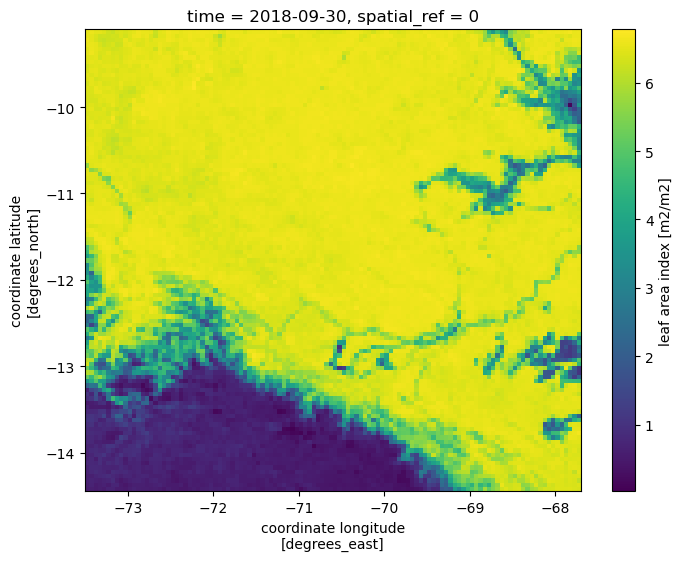

In [2]:
ds_lai.lai.isel(time=200).plot(figsize=(8,6))

In [3]:
example = glob.glob("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/*.tif")[1]

with rasterio.open(example) as src:
    print("CRS:", src.crs)
    print("Resolution:", src.res)
    print("Bounds:", src.bounds)

da = rio.open_rasterio("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_01.tif")
print(da.rio.crs)
print(da)

CRS: GEOGCS["Greenwich",DATUM["unnamed",SPHEROID["unnamed",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Resolution: (0.041666666666666664, 0.041666666666666664)
Bounds: BoundingBox(left=-73.5, bottom=-14.499999999999995, right=-67.70833333333333, top=-9.083333333333329)
GEOGCS["Greenwich",DATUM["unnamed",SPHEROID["unnamed",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
<xarray.DataArray (band: 7, y: 130, x: 139)> Size: 1MB
[126490 values with dtype=float64]
Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * y            (y) float64 1kB -9.104 -9.146 -9.187 ... -14.4 -14.44 -14.48
  * x            (x) float64 1kB -73.48 -73.44 -73.4 ... -67.81 -67.77 -67.73
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIF

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [4]:
# -----------------------
# 2. Load TerraClim TIFFs
# -----------------------
tif_folder = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/"
tif_files = sorted(glob.glob(os.path.join(tif_folder, "*.tif")))

data_vars = {}  # dictionary to hold each variable's DataArray
times = []

for f in tif_files:
    basename = os.path.basename(f)
    parts = basename.replace(".tif", "").split("_")
    year, month = int(parts[1]), int(parts[2])
    last_day = pd.Timestamp(year=year, month=month, day=1) + pd.offsets.MonthEnd(0)
    times.append(last_day)
    # print(last_day)
    
    da = rio.open_rasterio(f, masked=True)
    # print(da.sizes['band'])
    
    # Ensure band dimension exists
    # if 'band' not in da.dims:
    #     da = da.expand_dims('band')
    
    for b in range(da.sizes['band']):
        # print(b)
        var_name = f"band{b+1}"
        # print(var_name)
        band_da = da.isel(band=b)#.squeeze('band')
        band_da = band_da.expand_dims({'time': [last_day]})
        # print(band_da)
        
        if var_name in data_vars:
            data_vars[var_name].append(band_da)
        else:
            data_vars[var_name] = [band_da]

print(data_vars)
print(times)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

{'band1': [<xarray.DataArray (time: 1, y: 130, x: 139)> Size: 145kB
array([[[31.2, 31.1, 31. , ..., 30.5, 30.4, 30.5],
        [31.2, 31.1, 31. , ..., 30.5, 30.5, 30.4],
        [31.1, 31.1, 31.1, ..., 30.4, 30.4, 30.4],
        ...,
        [12.2, 12. , 12.4, ..., 30. , 29.8, 29.2],
        [11.1, 10.9, 11.3, ..., 30.1, 30.2, 30. ],
        [10.2, 10.9, 11.4, ..., 30.3, 30.3, 30.2]]], shape=(1, 130, 139))
Coordinates:
  * time         (time) datetime64[ns] 8B 2000-01-31
  * y            (y) float64 1kB -9.104 -9.146 -9.187 ... -14.4 -14.44 -14.48
  * x            (x) float64 1kB -73.48 -73.44 -73.4 ... -67.81 -67.77 -67.73
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0, <xarray.DataArray (time: 1, y: 130, x: 139)> Size: 145kB
array([[[30.8, 30.8, 30.7, ..., 30.1, 

In [5]:
# Combine each list of DataArrays into one along the time dimension
combined_vars = {}
for var_name, da_list in data_vars.items():
    # For each DA, drop the 'band' coordinate if it exists
    cleaned_list = [da.drop_vars('band', errors='ignore') for da in da_list]
    combined_vars[var_name] = xr.concat(cleaned_list, dim='time')

# Create the Dataset
ds_clim = xr.Dataset(combined_vars)

# Rename spatial dims if needed
ds_clim = ds_clim.rename({'x': 'lon', 'y': 'lat'})
ds_clim = ds_clim.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

print(ds_clim)

<xarray.Dataset> Size: 304MB
Dimensions:      (time: 300, lon: 139, lat: 130)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2000-01-31 2000-02-29 ... 2024-12-31
  * lon          (lon) float64 1kB -73.48 -73.44 -73.4 ... -67.81 -67.77 -67.73
  * lat          (lat) float64 1kB -9.104 -9.146 -9.187 ... -14.4 -14.44 -14.48
    spatial_ref  int64 8B 0
Data variables:
    band1        (time, lat, lon) float64 43MB 31.2 31.1 31.0 ... 31.9 31.9 31.7
    band2        (time, lat, lon) float64 43MB 21.4 21.3 21.2 ... 22.9 22.8 22.7
    band3        (time, lat, lon) float64 43MB 134.0 134.0 136.0 ... 170.0 172.0
    band4        (time, lat, lon) float64 43MB -1.59 -1.6 -1.59 ... -6.87 -6.89
    band5        (time, lat, lon) float64 43MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    band6        (time, lat, lon) float64 43MB 0.8 0.79 0.78 ... 1.08 1.08 1.06
    band7        (time, lat, lon) float64 43MB 157.7 156.9 156.0 ... 85.1 84.9


In [6]:
ds_clim_4326 = ds_clim.rio.reproject("EPSG:4326")
ds_clim_4326

<xarray.Dataset> Size: 304MB
Dimensions:      (x: 139, y: 130, time: 300)
Coordinates:
  * x            (x) float64 1kB -73.48 -73.44 -73.4 ... -67.81 -67.77 -67.73
  * y            (y) float64 1kB -9.104 -9.146 -9.187 ... -14.4 -14.44 -14.48
  * time         (time) datetime64[ns] 2kB 2000-01-31 2000-02-29 ... 2024-12-31
    spatial_ref  int64 8B 0
Data variables:
    band1        (time, y, x) float64 43MB 31.2 31.1 31.0 ... 31.9 31.9 31.7
    band2        (time, y, x) float64 43MB 21.4 21.3 21.2 ... 22.9 22.8 22.7
    band3        (time, y, x) float64 43MB 134.0 134.0 136.0 ... 170.0 172.0
    band4        (time, y, x) float64 43MB -1.59 -1.6 -1.59 ... -6.87 -6.89
    band5        (time, y, x) float64 43MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    band6        (time, y, x) float64 43MB 0.8 0.79 0.78 0.78 ... 1.08 1.08 1.06
    band7        (time, y, x) float64 43MB 157.7 156.9 156.0 ... 84.5 85.1 84.9

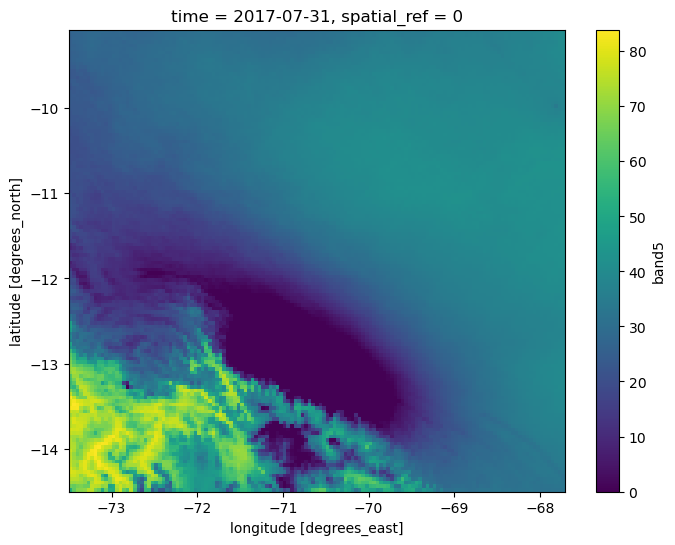

In [7]:
ds_clim_4326.band5.isel(time=210).plot(figsize=(8,6))

In [8]:
print(ds_clim_4326.rio.bounds())
print(ds_lai.rio.bounds())
print(ds_lai.rio.bounds())

(-73.5, -14.499999999999993, -67.70833333333334, -9.083333333333329)
(-73.4999984741211, -14.450001140810409, -67.69999847412109, -9.100001910947404)


In [13]:
ds_lai

<xarray.Dataset> Size: 23MB
Dimensions:      (time: 228, lat: 107, lon: 116)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
    spatial_ref  int64 8B 0
Data variables:
    lai          (time, lat, lon) float64 23MB ...
Attributes:
    citation:       [1] Lin, W., Yuan, H., Dai, Y. et al., 2022. Reprocessed ...
    contact:        Yuan, Hua (yuanh25@mail.sysu.edu.cn)
    creation_date:  20221119
    institution:    Land-Atmosphere Interaction Research Group at Sun Yat-sen...
    title:          LAI data sets for land surface and climate modelling

In [14]:
ds_clim = ds_clim_4326

# Ensure both are pd.DatetimeIndex
lai_times = pd.to_datetime(ds_lai.time.values)
clim_times = pd.to_datetime(ds_clim.time.values)

# Select only TerraClim times within LAI range
start_time = lai_times.min()
end_time = lai_times.max()

ds_clim_clipped = ds_clim.sel(time=slice(start_time, end_time))

print(ds_clim_clipped.time.values)

['2002-01-31T00:00:00.000000000' '2002-02-28T00:00:00.000000000'
 '2002-03-31T00:00:00.000000000' '2002-04-30T00:00:00.000000000'
 '2002-05-31T00:00:00.000000000' '2002-06-30T00:00:00.000000000'
 '2002-07-31T00:00:00.000000000' '2002-08-31T00:00:00.000000000'
 '2002-09-30T00:00:00.000000000' '2002-10-31T00:00:00.000000000'
 '2002-11-30T00:00:00.000000000' '2002-12-31T00:00:00.000000000'
 '2003-01-31T00:00:00.000000000' '2003-02-28T00:00:00.000000000'
 '2003-03-31T00:00:00.000000000' '2003-04-30T00:00:00.000000000'
 '2003-05-31T00:00:00.000000000' '2003-06-30T00:00:00.000000000'
 '2003-07-31T00:00:00.000000000' '2003-08-31T00:00:00.000000000'
 '2003-09-30T00:00:00.000000000' '2003-10-31T00:00:00.000000000'
 '2003-11-30T00:00:00.000000000' '2003-12-31T00:00:00.000000000'
 '2004-01-31T00:00:00.000000000' '2004-02-29T00:00:00.000000000'
 '2004-03-31T00:00:00.000000000' '2004-04-30T00:00:00.000000000'
 '2004-05-31T00:00:00.000000000' '2004-06-30T00:00:00.000000000'
 '2004-07-31T00:00:00.000

In [33]:
# Make sure both have CRS defined
ds_clim_clipped.rio.write_crs(ds_lai.rio.crs, inplace=True)

# Reproject and resample to match LAI
ds_clim_aligned = ds_clim_clipped.rio.reproject_match(ds_lai)

print(ds_clim_aligned)

NameError: name 'ds_clim_clipped' is not defined

In [16]:
new_band_names = ['tmmx', 'tmmn', 'pr', 'pdsi', 'def', 'vpd', 'soil']

# Create a mapping from old names to new names
rename_dict = {f'band{i+1}': name for i, name in enumerate(new_band_names)}

# Rename the data variables
ds_clim_renamed = ds_clim_aligned.rename(rename_dict)
ds_clim_renamed = ds_clim_renamed.rename({'x': 'lon', 'y': 'lat'})


# Check
print(ds_clim_renamed)

<xarray.Dataset> Size: 158MB
Dimensions:      (time: 228, lon: 116, lat: 107)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
    spatial_ref  int64 8B 0
Data variables:
    tmmx         (time, lat, lon) float64 23MB 32.1 32.0 31.9 ... 31.1 31.2 31.1
    tmmn         (time, lat, lon) float64 23MB 22.2 22.2 22.1 ... 22.0 22.1 21.9
    pr           (time, lat, lon) float64 23MB 359.0 361.0 370.0 ... 392.0 399.0
    pdsi         (time, lat, lon) float64 23MB -1.68 -1.65 -1.57 ... -2.09 -2.06
    def          (time, lat, lon) float64 23MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    vpd          (time, lat, lon) float64 23MB 0.89 0.88 0.87 ... 0.93 0.94 0.93
    soil         (time, lat, lon) float64 23MB 156.8 156.0 154.5 ... 234.9 229.8


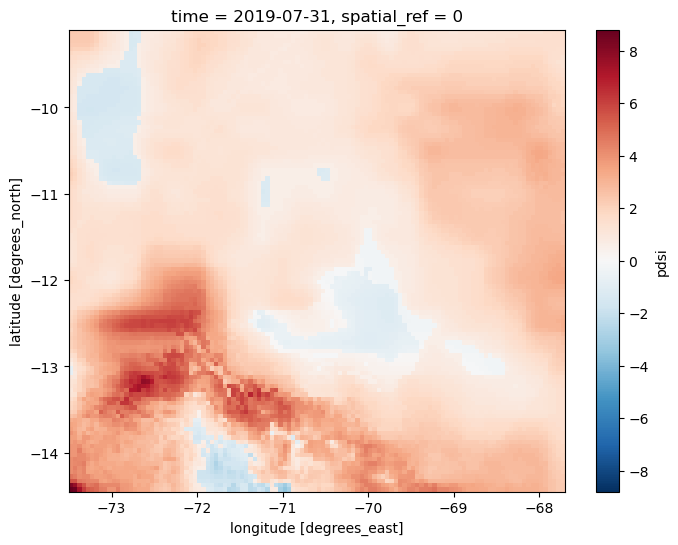

In [17]:
ds_clim_renamed.pdsi.isel(time=210).plot(figsize=(8,6))

In [18]:
# Suppose your dataset is ds_clim_renamed
# Pixel resolution in x (longitude) and y (latitude)
dx = float(ds_clim_renamed['lon'][1] - ds_clim_renamed['lon'][0])
dy = float(ds_clim_renamed['lat'][1] - ds_clim_renamed['lat'][0])

print(f"Pixel size in x (lon): {dx} degrees")
print(f"Pixel size in y (lat): {dy} degrees")

Pixel size in x (lon): 0.0500030517578125 degrees
Pixel size in y (lat): -0.049999237060546875 degrees


In [19]:
# Suppose your dataset is ds_clim_renamed
# Pixel resolution in x (longitude) and y (latitude)
dx = float(ds_lai['lon'][1] - ds_lai['lon'][0])
dy = float(ds_lai['lat'][1] - ds_lai['lat'][0])

print(f"Pixel size in x (lon): {dx} degrees")
print(f"Pixel size in y (lat): {dy} degrees")

Pixel size in x (lon): 0.0500030517578125 degrees
Pixel size in y (lat): -0.049999237060546875 degrees


In [20]:
da = ds_lai['lai']
da.rio  # This will attach rioxarray functionality if not already attached

# Check the CRS
print(da.rio.crs)

EPSG:4326


In [21]:
ds_combined = xr.merge([ds_clim_renamed, ds_lai])

print(ds_combined)

<xarray.Dataset> Size: 181MB
Dimensions:      (time: 228, lon: 116, lat: 107)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
    spatial_ref  int64 8B 0
Data variables:
    tmmx         (time, lat, lon) float64 23MB 32.1 32.0 31.9 ... 31.1 31.2 31.1
    tmmn         (time, lat, lon) float64 23MB 22.2 22.2 22.1 ... 22.0 22.1 21.9
    pr           (time, lat, lon) float64 23MB 359.0 361.0 370.0 ... 392.0 399.0
    pdsi         (time, lat, lon) float64 23MB -1.68 -1.65 -1.57 ... -2.09 -2.06
    def          (time, lat, lon) float64 23MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    vpd          (time, lat, lon) float64 23MB 0.89 0.88 0.87 ... 0.93 0.94 0.93
    soil         (time, lat, lon) float64 23MB 156.8 156.0 154.5 ... 234.9 229.8
    lai          (time, lat, lon) float64 23MB ...


/tmp/ipykernel_83/1042284820.py:1: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_combined = xr.merge([ds_clim_renamed, ds_lai])


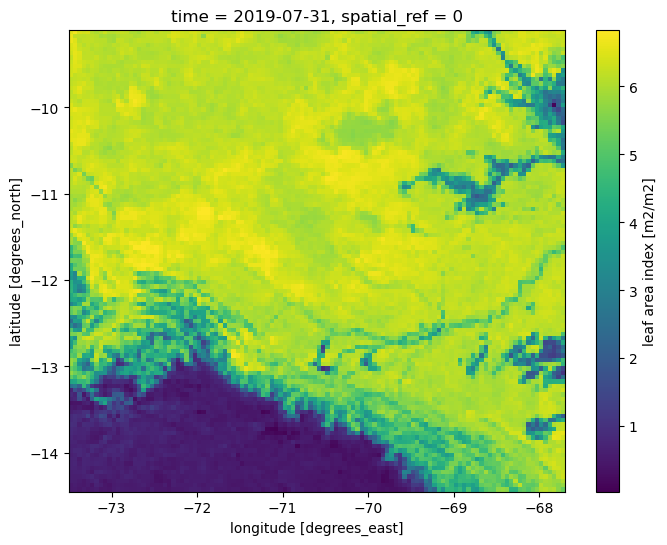

In [22]:
ds_combined.lai.isel(time=210).plot(figsize=(8,6))

In [23]:
lat = float(ds_combined['lat'].mean())  # mean latitude of the dataset

dx_deg = float(ds_combined['lon'][1] - ds_combined['lon'][0])
dy_deg = float(ds_combined['lat'][1] - ds_combined['lat'][0])

dx_m = dx_deg * 111320 * np.cos(np.deg2rad(lat))  # meters per pixel in x
dy_m = dy_deg * 111320                             # meters per pixel in y

print(f"Pixel size in x: {dx_m:.2f} meters")
print(f"Pixel size in y: {dy_m:.2f} meters")

Pixel size in x: 5449.20 meters
Pixel size in y: -5565.92 meters


In [24]:
# Export to a new Zarr directory
output_path = "/home/jovyan/large_files/climLai_merged.nc"
ds_combined.to_netcdf(output_path)

# Import 
#
#
#
#

In [6]:
path = "/home/jovyan/large_files/climLai_merged.nc"
ds_combined = xr.open_dataset(path)

# Set spatial dims and CRS
ds_lai = ds_lai.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)
# ds_lai = ds_lai.rio.write_crs("EPSG:4326", inplace=True)  # assuming it's lat/lon WGS84

if ds_combined.rio.crs is None:
    ds_combined = ds_combined.rio.write_crs("EPSG:4326")

print(ds_combined)
# print(ds_lai.time.values)  # check dates
da = ds_combined['lai']
da.rio  # This will attach rioxarray functionality if not already attached



# Check the CRS
print(da.rio.crs)
print(da.dims)
# Print all timestamps
print(ds_combined.time.values)

<xarray.Dataset> Size: 181MB
Dimensions:      (time: 228, lat: 107, lon: 116)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
    spatial_ref  int64 8B 0
Data variables:
    tmmx         (time, lat, lon) float64 23MB ...
    tmmn         (time, lat, lon) float64 23MB ...
    pr           (time, lat, lon) float64 23MB ...
    pdsi         (time, lat, lon) float64 23MB ...
    def          (time, lat, lon) float64 23MB ...
    vpd          (time, lat, lon) float64 23MB ...
    soil         (time, lat, lon) float64 23MB ...
    lai          (time, lat, lon) float64 23MB ...
EPSG:4326
('time', 'lat', 'lon')
['2002-01-31T00:00:00.000000000' '2002-02-28T00:00:00.000000000'
 '2002-03-31T00:00:00.000000000' '2002-04-30T00:00:00.000000000'
 '2002-05-31T00:00:00.000000000' '2002-06-30T00:00:00.000000000'

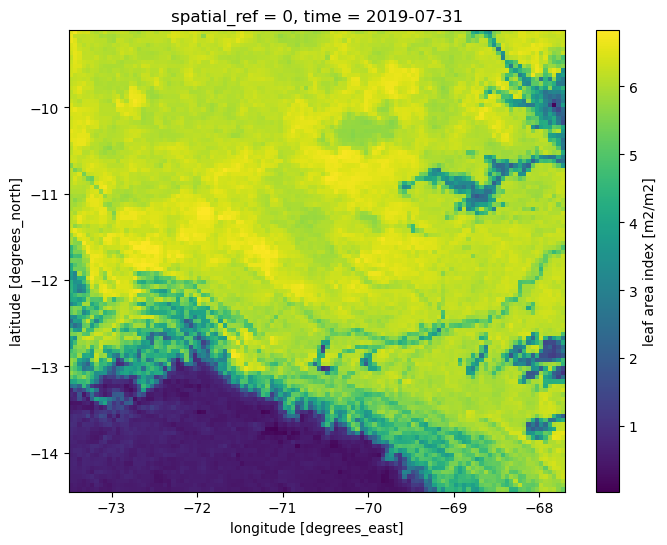

In [7]:
ds_combined.lai.isel(time=210).plot(figsize=(8,6))


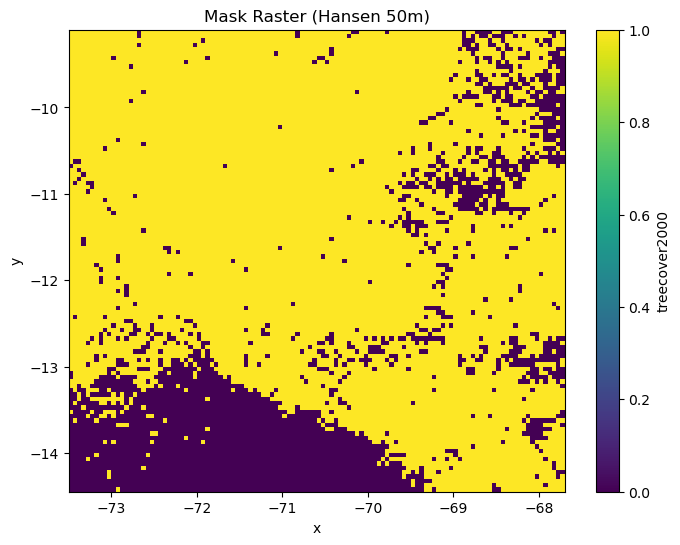

In [14]:
# 1️⃣ Load the mask GeoTIFF
mask_tif = rio.open_rasterio("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/hansenMask_mode_50m_v2.tif")

if 'band' in mask_tif.dims and mask_tif.sizes['band'] == 1:
    mask_tif = mask_tif.squeeze('band')

mask_tif.plot(figsize=(8, 6))
plt.title("Mask Raster (Hansen 50m)")
plt.show()


In [13]:
print("ds_combined CRS:", ds_combined.rio.crs)
print("ds_combined transform:", ds_combined.rio.transform())
print("ds_combined pixel size:", ds_combined.rio.resolution())
print("ds_combined shape:", ds_combined.rio.shape)

print("mask CRS:", mask_tif.rio.crs)
print("mask transform:", mask_tif.rio.transform())
print("mask pixel size:", mask_tif.rio.resolution())
print("mask shape:", mask_tif.rio.shape)

print(mask_tif.dims)

ds_combined CRS: EPSG:4326
ds_combined transform: | 0.05, 0.00,-73.50|
| 0.00,-0.05,-9.10|
| 0.00, 0.00, 1.00|
ds_combined pixel size: (0.05, -0.04999999280245799)
ds_combined shape: (107, 116)
mask CRS: EPSG:4326
mask transform: | 0.05, 0.00,-73.50|
| 0.00,-0.05,-9.10|
| 0.00, 0.00, 1.00|
mask pixel size: (0.05, -0.04999999280245799)
mask shape: (107, 116)
('y', 'x')


In [16]:
# 4️⃣ Expand mask to have the same time dimension as ds_combined
mask_data = xr.DataArray(
    np.broadcast_to(mask_tif.values, (ds_combined.dims['time'], *mask_tif.shape)),
    coords={
        "time": ds_combined.time,
        "lat": ds_combined.lat,
        "lon": ds_combined.lon
    },
    dims=("time", "lat", "lon")
)

# 5️⃣ Optionally wrap as Dataset for merging
mask_ds = xr.Dataset({"forestMask": mask_data})

# ✅ Check
print(mask_ds)

<xarray.Dataset> Size: 3MB
Dimensions:     (time: 228, lat: 107, lon: 116)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat         (lat) float32 428B -9.125 -9.175 -9.225 ... -14.33 -14.38 -14.43
  * lon         (lon) float32 464B -73.47 -73.42 -73.38 ... -67.82 -67.78 -67.72
Data variables:
    forestMask  (time, lat, lon) uint8 3MB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1


/tmp/ipykernel_89/3628050788.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  np.broadcast_to(mask_tif.values, (ds_combined.dims['time'], *mask_tif.shape)),


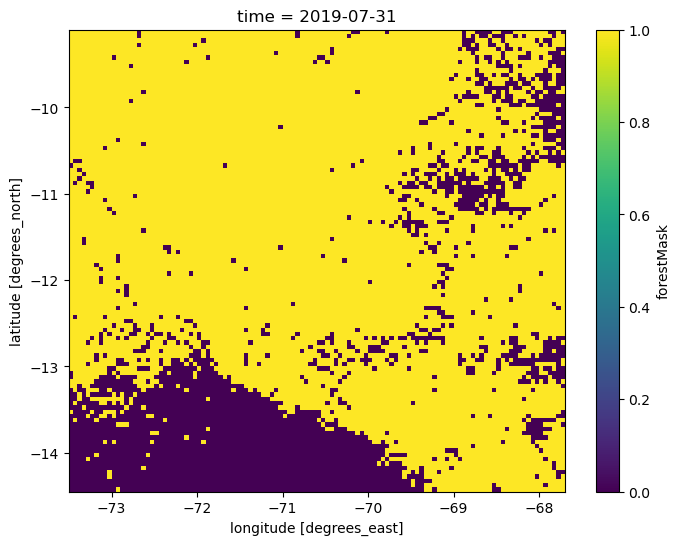

In [17]:
mask_ds.forestMask.isel(time=210).plot(figsize=(8,6))

In [19]:
ds_withMask = xr.merge([ds_combined, mask_ds])

ds_withMask

<xarray.Dataset> Size: 184MB
Dimensions:      (time: 228, lat: 107, lon: 116)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
    spatial_ref  int64 8B 0
Data variables:
    tmmx         (time, lat, lon) float64 23MB ...
    tmmn         (time, lat, lon) float64 23MB ...
    pr           (time, lat, lon) float64 23MB ...
    pdsi         (time, lat, lon) float64 23MB ...
    def          (time, lat, lon) float64 23MB ...
    vpd          (time, lat, lon) float64 23MB ...
    soil         (time, lat, lon) float64 23MB ...
    lai          (time, lat, lon) float64 23MB ...
    forestMask   (time, lat, lon) uint8 3MB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1

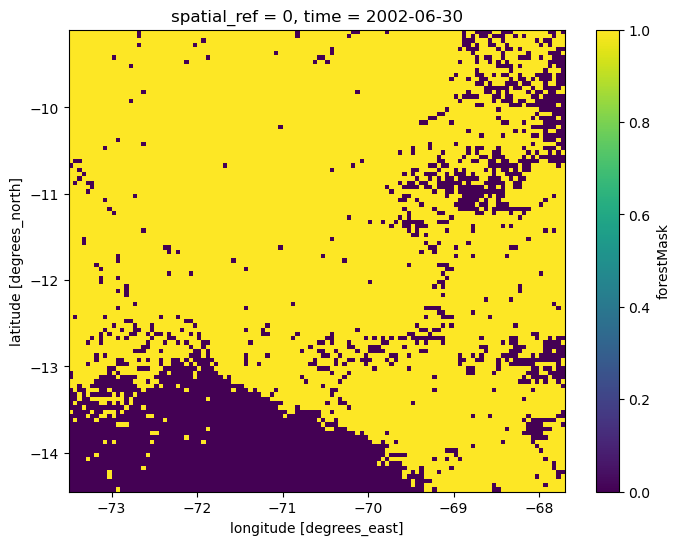

In [23]:
ds_withMask.forestMask.isel(time=5).plot(figsize=(8,6))

In [27]:
mask = ds_withMask["forestMask"] > 0

masked_vars = {}
for var in ds_withMask.data_vars:
    if var != "forestMask":  # skip the mask itself
        masked_vars[var] = ds_withMask[var].where(mask)

ds_masked = xr.Dataset(masked_vars, coords=ds_withMask.coords)

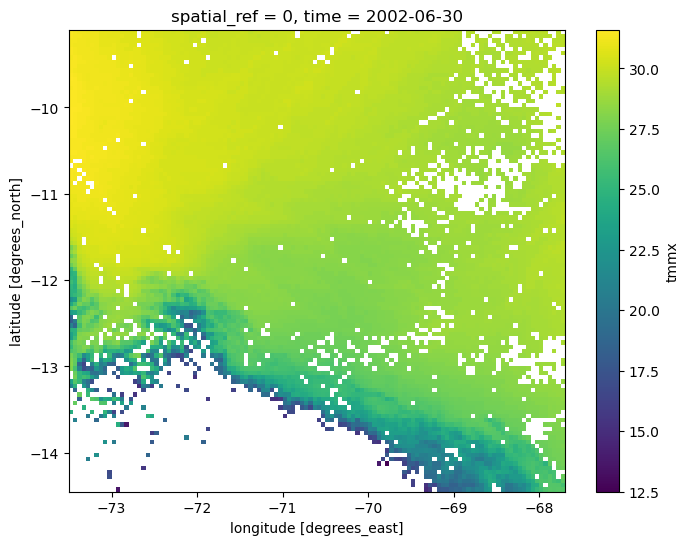

In [31]:
ds_masked.tmmx.isel(time=5).plot(figsize=(8,6))

In [30]:
output_path = "/home/jovyan/large_files/climLai_masked.nc"
ds_combined.to_netcdf(output_path)